# Measuring fairness in ranking

In this demonstration, we implement a metric based on the Kullback-Leibler (KL) divergence to measure the fairness of a ranking. 

The demonstration is based on this [paper](https://arxiv.org/pdf/1610.08559.pdf).




In [ ]:
!pip install ipytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ipytest
import pytest
from dataclasses import dataclass
from typing import List, Dict, Any
import random
import operator
import math
import numpy as np
import matplotlib.pyplot as plt

ipytest.autoconfig()

Class to represent the items that are ranked.

In [ ]:
@dataclass
class Item:
    """An item is represented with an id, a protected attribute, and its income."""
    id: int
    is_protected: bool
    income: int

In [ ]:
def create_random_ranking(n: int=100, nb_protected:int=50) -> List[Item]:
    """Create a random ranking witn n items.
    
    Args:
        n: Number of items in the ranking.
        nb_protected: Number of items in the protected group.
        
    Returns:
        Random ranking.
    """
    db = list()
    for i in range(0, n, 1):
        id, income = random.sample(range(900), 2)
        if i < nb_protected:
            db.append(Item(id, True, income))
        else:
            db.append(Item(id, False, income))
    db = sorted(db, key=lambda i: i.income, reverse=True)
    return db


### Unfair ranking generator

Refer to Algorithm 1 in this [paper](https://arxiv.org/pdf/1610.08559.pdf).


In [ ]:
def unfair_ranking_generator(ranking: List[Item], f: float) -> List[Item]:
    """Generate unfair ranking.
    Reproduce algorithm 1 from Yang and Stoyanovich.
    
    Args:
        ranking: Initial ranking.
        f: fairness probability.
        
    Returns:
        Unfair ranking.
    """
    unfair_ranking = list()
    protected = list()
    not_protected = list()

    # Separate protected and non-protected items.
    for item in ranking:
        if item.is_protected:
            protected.append(item)
        else:
            not_protected.append(item)

    while protected and not_protected:
        p = random.uniform(0, 1)
        if p < f:
            unfair_ranking.append(protected.pop(0))
        else:
            unfair_ranking.append(not_protected.pop(0))
    unfair_ranking.extend(protected)
    unfair_ranking.extend(not_protected)
    return unfair_ranking

### Measure fairness

Kullback-Leibler (KL) divergence

$$d_{KL}(P||Q) = \sum_{i} P(i)log\frac{P(i)}{Q(i)}$$

$$P = \left(\frac{|S^+_{1..i}|}{i}, \frac{|S^-_{1..i}|}{i}\right), Q = \left(\frac{|S^+|}{N}, \frac{|S^-|}{N}\right)$$

In [ ]:
def compute_kld(p: List[float], q: List[float]) -> float:
    """Calculates KL divergence between 2 distributions.

    Args:
        p: Distribution 1.
        q: Distribution 2.
    
    Returns:
        KL divergence between 2 distributions.
    """
    epsilon = 1e-5

    kdl = 0.0
    for p1, p2 in zip(p, q):
        kdl += p1 * math.log((p1 + epsilon) / (p2 + epsilon))
    return kdl


Normalized discounted cumulative KL-divergence (NDKL)

$$NDKL(\tau_r) = \frac{1}{Z}\sum_{i=1}^{|\tau_r|}\frac{1}{log_2(i+1)}d_{KL}(P||Q)$$

$$Z = \sum_{i=1}^{|\tau_r|}\frac{1}{log_2(i+1)}$$

In [ ]:
def compute_ndkl(ranking: List[Item], q: List[float]) -> float:
    """Calculates normalized discounted cumulative KL-divergence (NDKL).

    Args:
        ranking: Ranking.
        q:  group protected membership in the over-all population.
    
    Returns:
        Normalized discounted cumulative KL-divergence.
    """

    n_items = len(ranking)
    # Normalizer
    Z = np.sum(1 / (np.log2(np.arange(1, n_items + 1) + 1)))

    total = 0.0
    for k in range(1, n_items + 1):
        item_attr_k = [item.is_protected for item in ranking[:k]]
        item_distr = [
            item_attr_k.count(True) / len(item_attr_k),
            item_attr_k.count(False) / len(item_attr_k),
        ]
        total += (1 / math.log2(k + 1)) * compute_kld(item_distr, q)
    ndkl = (1 / Z) * total
    return ndkl

### Experiment

Observe behavior of NDKL on synthetic dataset.

In [ ]:
N = 1000
NB_PROTECTED = [200, 500, 800]
FAIRNESS_SCORES = np.arange(0, 1.1, 0.1)

Compute NDKL for different fairness scores.

In [ ]:
def ndkl_scores(ranking:List[Item], nb_protected:int, fairness_scores=List[float]) -> List[float]:
    """Compute NDKL for different fairness scores.

    Args:
        ranking: Initial ranking.
        nb_protected: Number of protected items.
        fairness_scores: List of fairness scores to generate unfair rankings.
    Returns:
        List of NDKL score for each fairness scores.
    """
    scores = list()
    n = len(ranking)
    q = [nb_protected / n, (n-nb_protected)/n]

    for f in fairness_scores:
        unfair_ranking = unfair_ranking_generator(ranking, f)
        scores.append(compute_ndkl(unfair_ranking, q))

    return scores

Display NDKL for rankings with different proportions of items in the protected group.

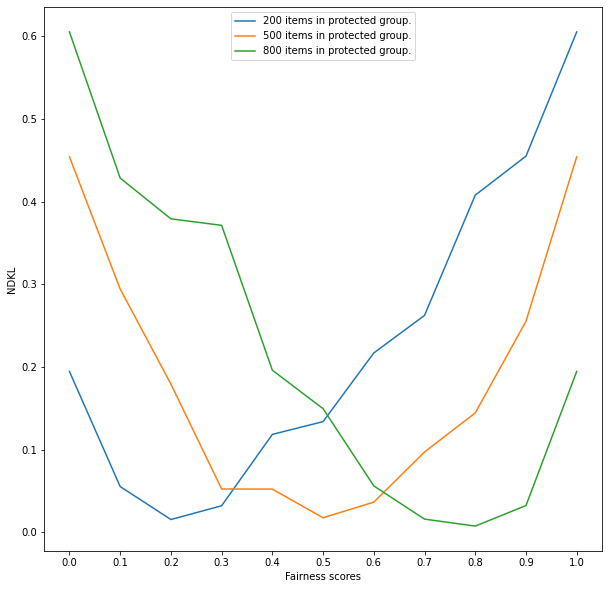

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for nb_protected in NB_PROTECTED:
    ranking = create_random_ranking(N, nb_protected)
    scores = ndkl_scores(ranking, nb_protected, FAIRNESS_SCORES)
    plt.plot(FAIRNESS_SCORES, scores, label=f"{nb_protected} items in protected group.")

plt.xlabel("Fairness scores")
plt.xticks(FAIRNESS_SCORES)
plt.ylabel("NDKL")
plt.legend()
plt.show()

### Test

In [ ]:
%%run_pytest[clean]

@pytest.mark.parametrize("nb_protected", [200, 400])
def test_ndkl_scores(nb_protected:int):
    n = 1000
    ranking = create_random_ranking(n, nb_protected)
    fairness_scores = np.arange(0, 1.1, 0.1)
    scores = ndkl_scores(ranking, nb_protected, fairness_scores)

    assert len(scores) == len(fairness_scores)
    assert scores.index(min(scores)) == np.where(fairness_scores==nb_protected/n)[0][0]



%%run_pytest[clean] and %%run_pytest are deprecated in favor of %%ipytest. %%ipytest will clean tests, evaluate the cell and then run pytest. To disable cleaning, configure ipytest with ipytest.config(clean=False).


..                                                                                           [100%]
2 passed in 0.95s
